In [70]:
using AlgebraicPetri

using LabelledArrays
using OrdinaryDiffEq
using Plots
using JSON

using Catlab
using Catlab.CategoricalAlgebra
using Catlab.Graphics
using Catlab.Programs
using Catlab.Theories
using Catlab.WiringDiagrams

display_uwd(ex) = to_graphviz(ex, box_labels=:name, junction_labels=:variable, edge_attrs=Dict(:len=>"1"));

In [71]:
ob(x::Symbol,n::Int) = codom(Open([x], LabelledReactionNet{Number,Int}(x=>n), [x])).ob;
function spontaneous_petri(transition::Symbol, rate::Number,
                           s::Symbol, s₀::Int,
                           t::Symbol, t₀::Int)
    Open(LabelledReactionNet{Number,Int}(unique((s=>s₀,t=>t₀)), (transition,rate)=>(s=>t)))
end;
function exposure_petri(transition::Symbol, rate::Number,
                        s::Symbol, s₀::Int,
                        i::Symbol, i₀::Int,
                        e::Symbol, e₀::Int)
    Open(LabelledReactionNet{Number,Int}(unique((s=>s₀,i=>i₀,e=>e₀)), (transition,rate)=>((s,i)=>(e,i))))
end;

### define parameters

In [231]:
beta = [0.5, 1.0, 2.0, 0.5];
epislon = [0.4, 0.1, 0.2, 0.5]; # both
#epislon = [0, 0, 0, 0]; # only inner contact
#epislon = [1, 1, 1, 1]; # only random mixing
t_a = 2.9;
t_u = 2.72;
t_n = 6;
t_r = 3.5;

### define initial values

In [232]:
s0=[25,50,75,100];
e0=[0,0,0,0];
ia0=[0,0,0,0];
iyu0=[1,1,1,1];
iyn0=[0,0,0,0];
ru0=[0,0,0,0];
N = s0+e0+ia0+iyu0+iyn0+ru0;

## Example code to show the vector multiplication and parameter value of N

In [233]:
N

4-element Array{Int64,1}:
  26
  51
  76
 101

In [234]:
N_kl_k=N .* beta
N_kl_k

4-element Array{Float64,1}:
  13.0
  51.0
 152.0
  50.5

In [235]:
sum_N_kl_k = sum(N_kl_k)
sum_N_kl_k

266.5

### Define an `oapply` function that connects the building block Petri nets to the operations we will use in the model.

In [236]:
F(ex,n) = oapply(ex, Dict(
        :exposure_a=>exposure_petri(Symbol(:exp_a,n), (1-epislon[n])*beta[n]/N[n], Symbol(:S,n), s0[n], Symbol(:IA,n), ia0[n], Symbol(:E,n), e0[n]),
        :exposure_yu=>exposure_petri(Symbol(:exp_yu,n), (1-epislon[n])*beta[n]/N[n], Symbol(:S,n), s0[n], Symbol(:IYU,n), iyu0[n], Symbol(:E,n), e0[n]),
        :exposure_yn=>exposure_petri(Symbol(:exp_yn,n), (1-epislon[n])*beta[n]/N[n], Symbol(:S,n), s0[n], Symbol(:IYN,n), iyn0[n], Symbol(:E,n), e0[n]),
        :asymptomatic_infection=>spontaneous_petri(Symbol(:new_infec,n), 1/t_a, Symbol(:E,n), e0[n], Symbol(:IA,n), ia0[n]),
        :becoming_symptomatic=>spontaneous_petri(Symbol(:new_sympt,n), 1/t_u, Symbol(:IA,n), ia0[n], Symbol(:IYU,n), iyu0[n]),
        :undiagnosed_sympt_NonComplications=>spontaneous_petri(Symbol(:undix_noncomp,n), 1/t_n, Symbol(:IYU,n), iyu0[n], Symbol(:IYN,n), iyn0[n]),
        :undiagnosed_recovery=>spontaneous_petri(Symbol(:new_recover,n), 1/t_r, Symbol(:IYN,n), iyn0[n], Symbol(:RU,n), ru0[n])))

F (generic function with 2 methods)

### define the `COVID-19` aggregate model structure of undirected wiring diagram using the `@relation` macro

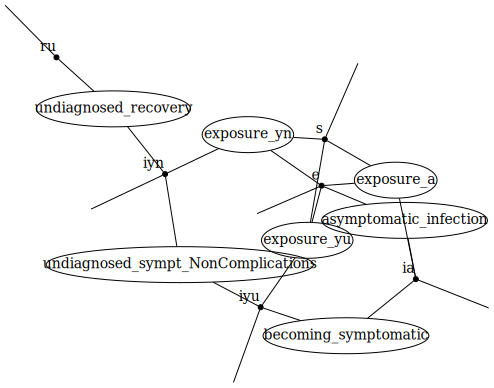

In [237]:
covid_aggrV1 = @relation (s, e, ia, iyu, iyn, ru) begin
    exposure_a(s, ia, e)
    exposure_yu(s, iyu, e)
    exposure_yn(s, iyn, e)
    asymptomatic_infection(e, ia)
    becoming_symptomatic(ia, iyu)
    undiagnosed_sympt_NonComplications(iyu, iyn)
    undiagnosed_recovery(iyn, ru)
end;
display_uwd(covid_aggrV1)

### define new infectious cross the population i and j, where i can equal to j

In [238]:
F_cx(ex, x,y) = oapply(ex, Dict(
        :exposure_a=>exposure_petri(Symbol(:exp_a,x,y), beta[x]*beta[y]*(epislon[x]*epislon[y])^0.5/sum_N_kl_k, Symbol(:S,x), s0[x], Symbol(:IA,y), ia0[y], Symbol(:E,x), e0[x]),
        :exposure_yu=>exposure_petri(Symbol(:exp_yu,x,y), beta[x]*beta[y]*(epislon[x]*epislon[y])^0.5/sum_N_kl_k, Symbol(:S,x), s0[x], Symbol(:IYU,y), iyu0[y], Symbol(:E,x), e0[x]),
        :exposure_yn=>exposure_petri(Symbol(:exp_yn,x,y), beta[x]*beta[y]*(epislon[x]*epislon[y])^0.5/sum_N_kl_k, Symbol(:S,x), s0[x], Symbol(:IYN,y), iyn0[y], Symbol(:E,x), e0[x]),
        :exposure_a1=>exposure_petri(Symbol(:exp_a,y,x), beta[x]*beta[y]*(epislon[x]*epislon[y])^0.5/sum_N_kl_k, Symbol(:S,y), s0[y], Symbol(:IA,x), ia0[x], Symbol(:E,y), e0[y]),
        :exposure_yu1=>exposure_petri(Symbol(:exp_yu,y,x), beta[x]*beta[y]*(epislon[x]*epislon[y])^0.5/sum_N_kl_k, Symbol(:S,y), s0[y], Symbol(:IYU,x), iyu0[x], Symbol(:E,y), e0[y]),
        :exposure_yn1=>exposure_petri(Symbol(:exp_yn,y,x), beta[x]*beta[y]*(epislon[x]*epislon[y])^0.5/sum_N_kl_k, Symbol(:S,y), s0[y], Symbol(:IYN,x), iyn0[x], Symbol(:E,y), e0[y])
        ),
    Dict(
        :s=>ob(Symbol(:S, x), s0[x]),
        :e=>ob(Symbol(:E, x), e0[x]),
        :ia=>ob(Symbol(:IA, x), ia0[x]),
        :iyu=>ob(Symbol(:IYU, x), iyu0[x]),
        :iyn=>ob(Symbol(:IYN, x), iyn0[x]),
        :ru=>ob(Symbol(:RU, x), ru0[x]),
        :s1=>ob(Symbol(:S, y), s0[y]),
        :e1=>ob(Symbol(:E, y), e0[y]),
        :ia1=>ob(Symbol(:IA, y), ia0[y]),
        :iyu1=>ob(Symbol(:IYU, y), iyu0[y]),
        :iyn1=>ob(Symbol(:IYN, y), iyn0[y]),
        :ru1=>ob(Symbol(:RU, y), ru0[y])
    ));

### Use this new presentation to define a model of cross exposure between two populations

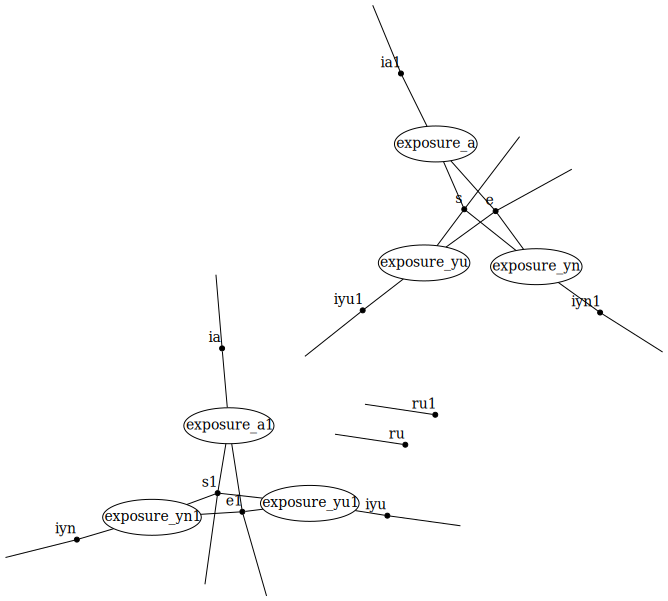

In [239]:
crossexposure = @relation (s, e, ia, iyu, iyn, ru, s1, e1, ia1, iyu1, iyn1, ru1) begin
    exposure_a(s, ia1, e)
    exposure_yu(s, iyu1, e)
    exposure_yn(s, iyn1, e)
    exposure_a1(s1, ia, e1)
    exposure_yu1(s1, iyu, e1)
    exposure_yn1(s1, iyn, e1)
end;
display_uwd(crossexposure)

### To combine these two models, we need to create a final relational model and use the `bundle_legs` function in our `oapply` that enables us to model 4 population wires instead of each individual state as a wire. Each of these populations has their own COEXIST model, and interact through cross exposure

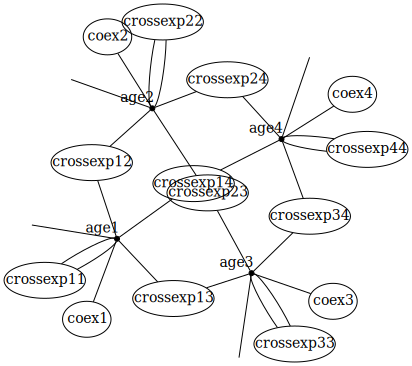

In [240]:
bundled_cross(x,y) = bundle_legs(F_cx(crossexposure, x, y), [tuple([1:6;]...), tuple([7:12;]...)])
bundled_coex(x) = bundle_legs(F(covid_aggrV1, x), [tuple([1:6;]...)])
F_tcx(ex) = oapply(ex, Dict(
    :crossexp11=>bundled_cross(1,1),
    :crossexp12=>bundled_cross(1,2),
    :crossexp13=>bundled_cross(1,3),
    :crossexp14=>bundled_cross(1,4),
    :crossexp22=>bundled_cross(2,2),
    :crossexp23=>bundled_cross(2,3),
    :crossexp24=>bundled_cross(2,4),
    :crossexp33=>bundled_cross(3,3),
    :crossexp34=>bundled_cross(3,4),
    :crossexp44=>bundled_cross(4,4),
    :coex1=>bundled_coex(1),
    :coex2=>bundled_coex(2),
    :coex3=>bundled_coex(3),
    :coex4=>bundled_coex(4)
        ));

covid_Age4_V1 = @relation (age1, age2, age3, age4) begin
    crossexp11(age1, age1)
    crossexp12(age1, age2)
    crossexp13(age1, age3)
    crossexp14(age1, age4)
    crossexp22(age2, age2)
    crossexp23(age2, age3)
    crossexp24(age2, age4)
    crossexp33(age3, age3)
    crossexp34(age3, age4)
    crossexp44(age4, age4)
    coex1(age1)
    coex2(age2)
    coex3(age3)
    coex4(age4)
end;
display_uwd(covid_Age4_V1)

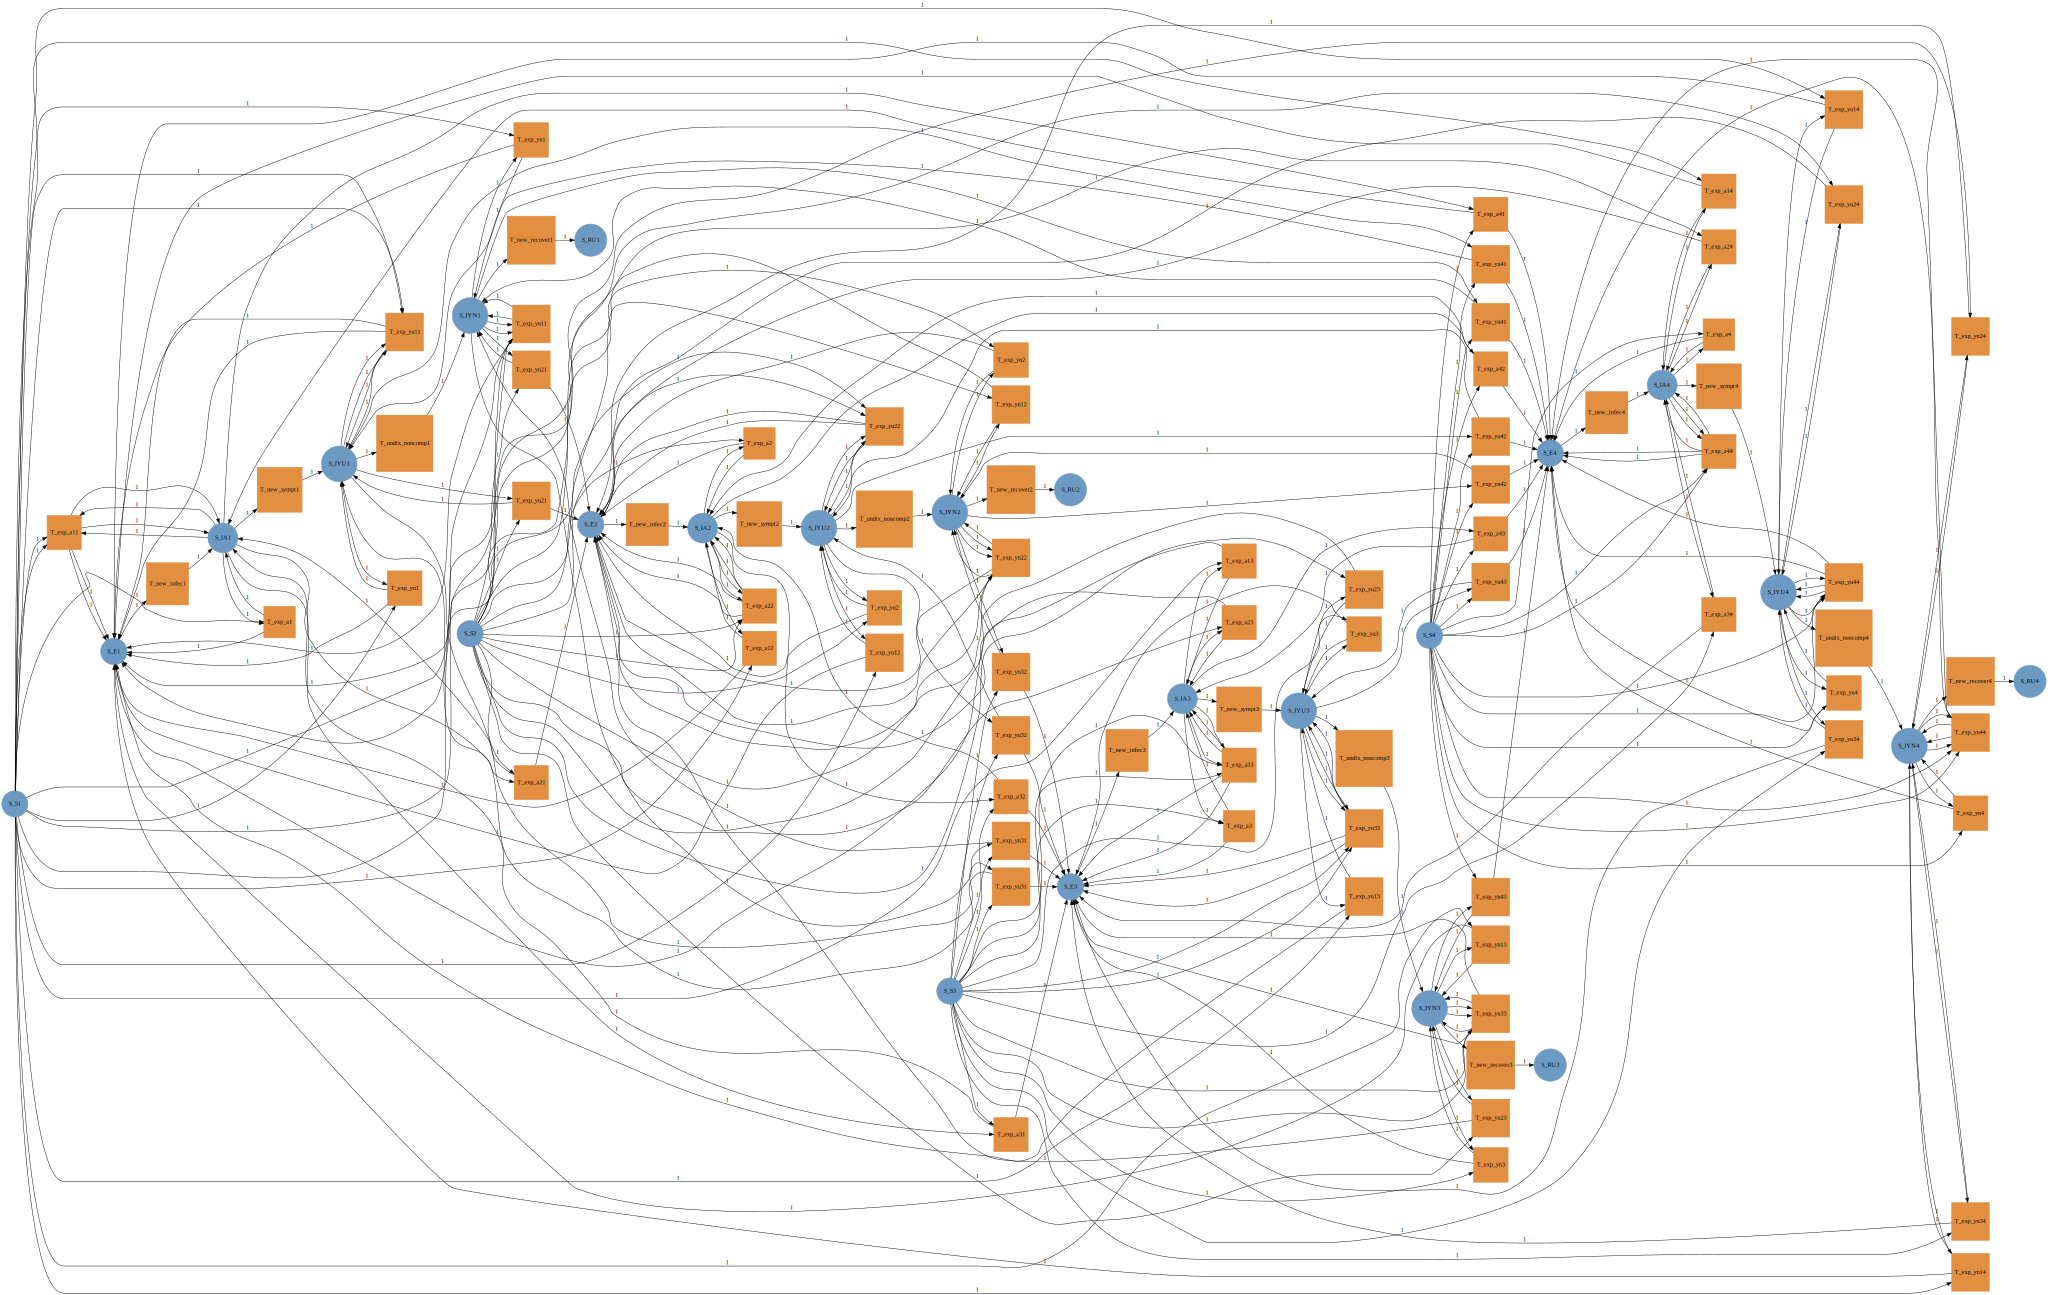

In [241]:
covid_Age4_V1_algpetri = apex(F_tcx(covid_Age4_V1))
Graph(covid_Age4_V1_algpetri)

In [242]:
#covidAggrV1_algpetri

In [243]:
#legs(F(covid_aggrV1))

In [244]:
#feet(F(covid_aggrV1))

In [245]:
#bundle_legs(F(covid_aggrV1), [(1,2), (3,4)]) ## think more of the bundle_legs, seems collaps two stocks together

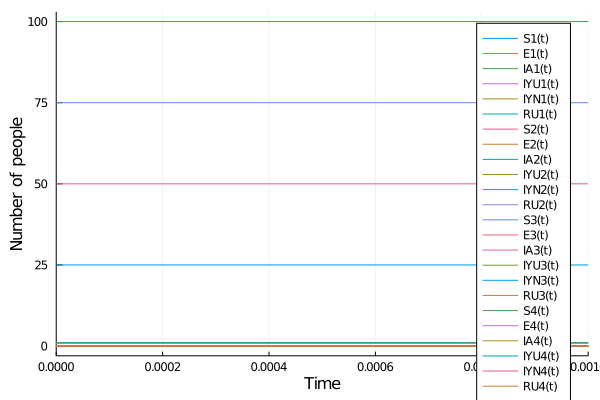

In [246]:
tspan = (0.0,100.0);
prob = ODEProblem(vectorfield(covid_Age4_V1_algpetri),concentrations(covid_Age4_V1_algpetri),tspan,rates(covid_Age4_V1_algpetri));
sol = solve(prob,Tsit5());
plot(sol, xlabel="Time", ylabel="Number of people")

In [225]:
#x\rasp -- using unicode in variable names
xʼ=1
xʼ


1

In [226]:
sol

retcode: Success
Interpolation: specialized 4th order "free" interpolation
t: 3-element Array{Float64,1}:
 0.0
 0.0007794806979871432
 0.001
u: 3-element Array{LArray{Float64,1,Array{Float64,1},(:S1, :E1, :IA1, :IYU1, :IYN1, :RU1, :S2, :E2, :IA2, :IYU2, :IYN2, :RU2, :S3, :E3, :IA3, :IYU3, :IYN3, :RU3, :S4, :E4, :IA4, :IYU4, :IYN4, :RU4)},1}:
 24-element LArray{Float64,1,Array{Float64,1},(:S1, :E1, :IA1, :IYU1, :IYN1, :RU1, :S2, :E2, :IA2, :IYU2, :IYN2, :RU2, :S3, :E3, :IA3, :IYU3, :IYN3, :RU3, :S4, :E4, :IA4, :IYU4, :IYN4, :RU4)}:
   :S1 => 25.0
   :E1 => 0.0
  :IA1 => 0.0
 :IYU1 => 1.0
 :IYN1 => 0.0
  :RU1 => 0.0
   :S2 => 50.0
   :E2 => 0.0
       ⋮
  :RU3 => 0.0
   :S4 => 100.0
   :E4 => 0.0
  :IA4 => 0.0
 :IYU4 => 1.0
 :IYN4 => 0.0
  :RU4 => 0.0
 24-element LArray{Float64,1,Array{Float64,1},(:S1, :E1, :IA1, :IYU1, :IYN1, :RU1, :S2, :E2, :IA2, :IYU2, :IYN2, :RU2, :S3, :E3, :IA3, :IYU3, :IYN3, :RU3, :S4, :E4, :IA4, :IYU4, :IYN4, :RU4)}:
   :S1 => 24.99983547599396
   :E1 => 0.0001645

In [227]:
show(prob.p)

76-element LArray{Float64,1,Array{Float64,1},(:exp_a11, :exp_yu11, :exp_yn11, :exp_a12, :exp_yu12, :exp_yn12, :exp_a21, :exp_yu21, :exp_yn21, :exp_a13, :exp_yu13, :exp_yn13, :exp_a31, :exp_yu31, :exp_yn31, :exp_a14, :exp_yu14, :exp_yn14, :exp_a41, :exp_yu41, :exp_yn41, :exp_a22, :exp_yu22, :exp_yn22, :exp_a23, :exp_yu23, :exp_yn23, :exp_a32, :exp_yu32, :exp_yn32, :exp_a24, :exp_yu24, :exp_yn24, :exp_a42, :exp_yu42, :exp_yn42, :exp_a33, :exp_yu33, :exp_yn33, :exp_a34, :exp_yu34, :exp_yn34, :exp_a43, :exp_yu43, :exp_yn43, :exp_a44, :exp_yu44, :exp_yn44, :exp_a1, :exp_yu1, :exp_yn1, :new_infec1, :new_sympt1, :undix_noncomp1, :new_recover1, :exp_a2, :exp_yu2, :exp_yn2, :new_infec2, :new_sympt2, :undix_noncomp2, :new_recover2, :exp_a3, :exp_yu3, :exp_yn3, :new_infec3, :new_sympt3, :undix_noncomp3, :new_recover3, :exp_a4, :exp_yu4, :exp_yn4, :new_infec4, :new_sympt4, :undix_noncomp4, :new_recover4)}:
        :exp_a11 => 0.0009380863039399625
       :exp_yu11 => 0.0009380863039399625
       :

In [228]:
show(sol)

retcode: Success
Interpolation: specialized 4th order "free" interpolation
t: [0.0, 0.0007794806979871432, 0.001]
u: LArray{Float64,1,Array{Float64,1},(:S1, :E1, :IA1, :IYU1, :IYN1, :RU1, :S2, :E2, :IA2, :IYU2, :IYN2, :RU2, :S3, :E3, :IA3, :IYU3, :IYN3, :RU3, :S4, :E4, :IA4, :IYU4, :IYN4, :RU4)}[24-element LArray{Float64,1,Array{Float64,1},(:S1, :E1, :IA1, :IYU1, :IYN1, :RU1, :S2, :E2, :IA2, :IYU2, :IYN2, :RU2, :S3, :E3, :IA3, :IYU3, :IYN3, :RU3, :S4, :E4, :IA4, :IYU4, :IYN4, :RU4)}:
   :S1 => 25.0
   :E1 => 0.0
  :IA1 => 0.0
 :IYU1 => 1.0
 :IYN1 => 0.0
  :RU1 => 0.0
   :S2 => 50.0
   :E2 => 0.0
  :IA2 => 0.0
 :IYU2 => 1.0
 :IYN2 => 0.0
  :RU2 => 0.0
   :S3 => 75.0
   :E3 => 0.0
  :IA3 => 0.0
 :IYU3 => 1.0
 :IYN3 => 0.0
  :RU3 => 0.0
   :S4 => 100.0
   :E4 => 0.0
  :IA4 => 0.0
 :IYU4 => 1.0
 :IYN4 => 0.0
  :RU4 => 0.0, 24-element LArray{Float64,1,Array{Float64,1},(:S1, :E1, :IA1, :IYU1, :IYN1, :RU1, :S2, :E2, :IA2, :IYU2, :IYN2, :RU2, :S3, :E3, :IA3, :IYU3, :IYN3, :RU3, :S4, :E4, :IA4,

In [229]:
(2*3)^0.5

2.449489742783178

In [230]:
2^0.5*3^0.5

2.4494897427831783